## Task 4: Popular Dishes and Task 5: Restaurant Recommendation ##

For task #4 I decided to figure out what is the most popular sandwich. I had from the previous task a set of dishes from 'American (New)' category. In additional I decided to not stop only o sandwich but try to find most closes dishes to sandwiches. 

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import BooleanType

basePath = 'dataminingcapstone-001'
workingDir = os.path.join(os.curdir, basePath)

In [2]:
sqlContext = SQLContext(sc)

targetDir = os.path.join(workingDir, 'yelp_dataset_challenge_academic_dataset')

businessJSON = os.path.join(targetDir, 'yelp_academic_dataset_business.json')
businessDF = sqlContext.read.json(businessJSON)

reviewsJSON = os.path.join(targetDir, 'yelp_academic_dataset_review.json')
reviewsDF = sqlContext.read.json(reviewsJSON)

contains = udf(lambda xs, val: val in xs, BooleanType())
restaurantsDF = businessDF[contains(businessDF.categories, lit(u'American (New)'))]

selectedReviewsDF = reviewsDF.join(restaurantsDF,\
                                       restaurantsDF.business_id == reviewsDF.business_id)    
rewiewsRDD = selectedReviewsDF.select("text").map(lambda x: x.text)

In [3]:
import string

remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
wordsRDD = rewiewsRDD.map(lambda x: x.translate(remove_punctuation_map).lower()).map(lambda row: row.split(" "))

In [4]:
from pyspark.mllib.feature import Word2Vec

word2vec = Word2Vec()
model = word2vec.fit(wordsRDD)

In [5]:
print 'synonyms for word: \'{}\''.format('sandwich')
synonyms = model.findSynonyms('sandwich', 5)
for synonym, cosine_distance in synonyms:
    print("\t{}: {}".format(synonym.encode('utf-8'), cosine_distance))

synonyms for word: 'sandwich'
	panini: 1.69841198009
	sandwhich: 1.69731582704
	wrap: 1.64400842964
	reuben: 1.62241896087
	turkey: 1.58040674046


In [6]:
core_dish = [x[0] for x in synonyms]
core_dish.append(u'sandwich')

print core_dish

[u'panini', u'sandwhich', u'wrap', u'reuben', u'turkey', u'sandwich']


In [7]:
dish_file_path = os.path.join(workingDir, 'dishes.txt')
dish_names = (sc.textFile(dish_file_path)
              .filter(lambda dish_name: 
                      any(word in dish_name for word in core_dish))
              .collect())

print "length of dish names: {}".format(len(dish_names))
print dish_names

length of dish names: 268
[u'turkey burger', u'chicken sandwich', u'chicken lettuce wraps', u'steak sandwich', u'pulled pork sandwich', u'club sandwich', u'brisket sandwich', u'cuban sandwich', u'lettuce wraps', u'ice cream sandwich', u'spicy chicken wrap', u'sandwich with sweet potato fries', u'turkey sandwich', u'bahn mi sandwich', u'salad sandwich', u'sandwich bread', u'panini sandwich', u'veggie sandwich', u'grilled veggie sandwich', u'ground turkey', u'grilled cheese sandwiches', u'portobello sandwich', u'prosciutto sandwich', u'prime rib sandwich', u'buffalo chicken wrap', u'buffalo chicken sandwich', u'roasted turkey', u'turkey club sandwich', u'turkey burgers', u'fried egg sandwich', u'turkey sausage', u'grilled cheese sandwich', u'french dip sandwich', u'short rib grilled cheese sandwich', u'meatloaf sandwich', u'ruben sandwich', u'rosemary chicken sandwich', u'chicken salad sandwich', u'turkey pita', u'bacon wrapped shrimp', u'chicken wraps', u'beer bread sandwiches', u'chick

In [10]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

def lemmatize_phrase(phrase):
    return " ".join([wnl.lemmatize(w) for w in phrase.split()])

In [12]:
normalized_dish_names = {lemmatize_phrase(w) for w in dish_names}

def contains_count(name):
    count = 0
    for w in normalized_dish_names:
        if name in w:
            count += 1
    return count

unique_dish_names = [w for w in normalized_dish_names if contains_count(w) == 1]

print "length of dish names: {}".format(len(unique_dish_names))

print unique_dish_names

length of dish names: 192
[u'tuna fish sandwich', u'bacon wrapped rabbit', u'steak wrap', u'salmon sandwich', u'pastrami reuben', u'lobster roll sandwich', u'ham and cheese sandwich', u'limburger sandwich', u'beef on weck sandwich', u'filet-o-fish sandwich', u'turkey bolognese', u"fool's gold loaf sandwich", u'turkey burger', u'turkey club sandwich', u'fried bolognsandwich', u'portabellsandwich', u'denver sandwich', u'egg salad sandwich', u'bologna sandwich', u'walleye sandwich', u'fluffernutter sandwich', u'bahn mi sandwich', u'sandwich with sweet potato fry', u'quarter pounder sandwich', u'ruben sandwich', u'truffled egg sandwich', u'lavosh wrap', u'peanut butter, banana and bacon sandwich', u'hot brown sandwich', u'ahi tunlettuce wrap', u'caprese sandwich', u'mcgriddles sandwich', u'dagwood sandwich', u'blt sandwich', u'crab sandwich', u'turkey and stuffing', u'turkey pastrami sandwich', u'short rib sandwich', u'pitsandwich', u'sailor sandwich', u'cheese dream sandwich', u'roast bee

In [45]:
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

focusedReviewsRDD = rewiewsRDD.filter(lambda review: any(word in review for word in core_dish))

preprocessedReviewRDD = (focusedReviewsRDD
                            .map(lambda x: x.translate(remove_punctuation_map))
                            .map(lambda review: lemmatize_phrase(review))
                        )
preprocessedReviewRDD.cache()

PythonRDD[757] at RDD at PythonRDD.scala:43

In [46]:
print preprocessedReviewRDD.count()

10733


In [47]:
def filter_by_dish_name(dish_name):
    return preprocessedReviewRDD.filter(lambda review: dish_name in review)

dish_names_occurrence = {name: filter_by_dish_name(name) for name in unique_dish_names}

In [48]:
dish_names_occurrence_count = [(name, rdd.count()) for name, rdd in dish_names_occurrence.items()]
non_empty_occurrence_count = [(name, count) for name, count in dish_names_occurrence_count if count != 0]

print non_empty_occurrence_count

[(u'bacon wrapped rabbit', 3), (u'steak wrap', 24), (u'salmon sandwich', 38), (u'pastrami reuben', 5), (u'lobster roll sandwich', 1), (u'ham and cheese sandwich', 17), (u'turkey bolognese', 12), (u'turkey burger', 354), (u'turkey club sandwich', 17), (u'egg salad sandwich', 20), (u'walleye sandwich', 5), (u'bahn mi sandwich', 5), (u'sandwich with sweet potato fry', 22), (u'ruben sandwich', 3), (u'truffled egg sandwich', 23), (u'lavosh wrap', 14), (u'caprese sandwich', 27), (u'blt sandwich', 6), (u'crab sandwich', 16), (u'turkey and stuffing', 6), (u'turkey wrap', 32), (u'short rib sandwich', 21), (u'salad and sandwich', 96), (u'roast beef panini', 9), (u'fried egg sandwich', 17), (u'reuben sandwich', 14), (u'turkey bacon', 59), (u'bacon wrapped pork tenderloin', 12), (u'biloxi buttermilk fried chicken sandwich', 2), (u'brown bag chicken sandwich', 19), (u'turkey sandwich', 141), (u'cuban sandwich', 26), (u'turkey panini', 19), (u'corned beef sandwich', 11), (u'chicken pesto sandwich', 

In [88]:
print len(non_empty_occurrence_count)

134


In [49]:
import operator

sorted_names = sorted(non_empty_occurrence_count, key=operator.itemgetter(1), reverse=True)[:80]
dishes_rdd = [(name, dish_names_occurrence[name]) for name, count in  sorted_names]

In [183]:
middle_ticks = [2, 3, 4]
ticks = [1] + middle_ticks + [12]
print ticks

[1, 2, 3, 4, 12]


In [238]:
%matplotlib inline

import operator
import numpy as np
import matplotlib.pyplot as plt

def showBar(data, title, ylabel, xlabel, labels_y = 3, labels = None, color_points = None, middle_ticks = None): 
    length = len(data)
    ind = np.arange(length)
    width = 0.5
    
    counts = [c for (names, c) in data]
    
    if color_points:
        min_color_points = min(color_points)
        max_color_points = max(color_points)
        length_color_points = max_color_points - min_color_points

        norm_color_points = [(color_point - min_color_points) / length_color_points for color_point in color_points]
        
        color_map = plt.get_cmap('coolwarm')
        colors = np.array([color_map(color_point) for color_point in norm_color_points])

        heatmap = plt.scatter(ind, ind, c = color_points, cmap = 'coolwarm')
        plt.clf()
        
        fig, ax = plt.subplots()

        bar = ax.bar(ind, counts, color=colors)

        if middle_ticks:
            ticks = [min_color_points] + middle_ticks + [max_color_points]
        else:
            ticks = None
           
        cbar = plt.colorbar(heatmap, ticks = ticks)
    else:
        fig, ax = plt.subplots()
        bar = ax.bar(ind, counts, color='r')

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    plt.xticks(ind + width, [name for (name, c) in data], rotation='vertical') 
    
    if not labels:
        labels = counts

    def autolabel(rects):
        idx = 0
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + 0.8, height + labels_y, str(labels[idx]), ha='center', va='bottom', rotation='vertical')               
            idx += 1
            
    autolabel(bar)
        
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('reviews_count_per_dish.png', dpi=200)

    plt.show()

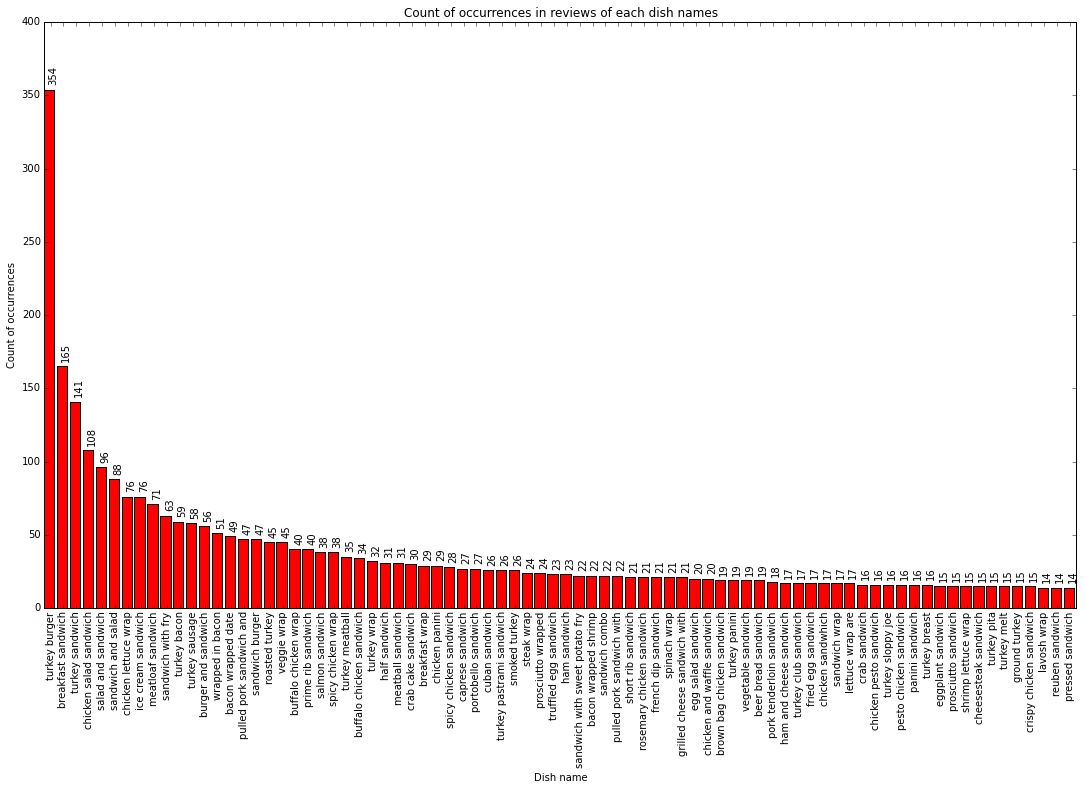

In [185]:
showBar(sorted_names, 
        'Count of occurrences in reviews of each dish names', 
        'Count of occurrences', 
        'Dish name')

## Sentiment analysis ##

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
vectorizer.fit_transform(preprocessedReviewRDD.toLocalIterator())
features = vectorizer.get_feature_names()

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
cv.fit_transform(preprocessedReviewRDD.toLocalIterator())

cv_features = vectorizer.get_feature_names()

In [78]:
def cv_feature_extractor(words):
    v = cv.transform([" ".join(words)]).toarray()[0]
    return {cv_features[i]: v[i] for i in range(0, len(v))}

In [69]:
def tfidf_feature_extractor(words):
    v = vectorizer.transform([" ".join(words)]).toarray()[0]
    return {features[i]: v[i] for i in range(0, len(v))}

In [82]:
from textblob import Blobber
from textblob.en.sentiments import NaiveBayesAnalyzer

naiveBayesAnalyzer = NaiveBayesAnalyzer()#feature_extractor = cv_feature_extractor)
naiveBayesAnalyzer.train()

blobber = Blobber(analyzer = naiveBayesAnalyzer)

In [83]:
def eveluate_polarity(review):
    if not review.strip():
        return 0.0
    
    blob = blobber(review) 
    return blob.sentiment.p_pos - blob.sentiment.p_neg

def eveluate_mean_polarity(name, rdd):
    m = rdd.map(lambda x: eveluate_polarity(x)).mean()
    print "\'{}\' polarity mean is: {}".format(name, m)
    return m

In [84]:
dish_names_polarity = [(name, eveluate_mean_polarity(name, rdd)) for name, rdd in dishes_rdd]

'turkey burger' polarity mean is: 0.312813571043
'breakfast sandwich' polarity mean is: 0.256254775859
'turkey sandwich' polarity mean is: 0.0885667546897
'chicken salad sandwich' polarity mean is: 0.389364307538
'salad and sandwich' polarity mean is: 0.623338492526
'sandwich and salad' polarity mean is: 0.534482381369
'chicken lettuce wrap' polarity mean is: 0.745058665883
'ice cream sandwich' polarity mean is: 0.658963106722
'meatloaf sandwich' polarity mean is: 0.407030802969
'sandwich with fry' polarity mean is: 0.36040843454
'turkey bacon' polarity mean is: 0.293478496523
'turkey sausage' polarity mean is: 0.326578665493
'burger and sandwich' polarity mean is: 0.548499050563
'wrapped in bacon' polarity mean is: 0.60263259197
'bacon wrapped date' polarity mean is: 0.736077136939
'pulled pork sandwich and' polarity mean is: 0.29779484942
'sandwich burger' polarity mean is: 0.397418030315
'roasted turkey' polarity mean is: 0.373227168932
'veggie wrap' polarity mean is: 0.641628168407

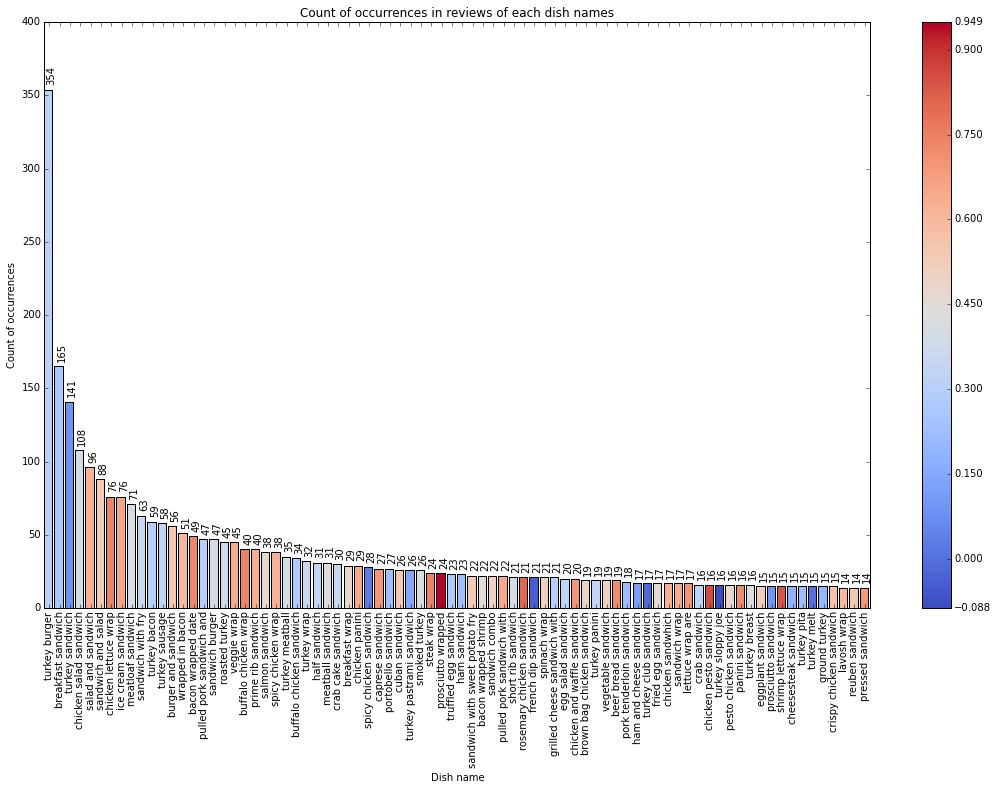

In [186]:
polarities = [polarity for name, polarity in dish_names_polarity]

showBar(sorted_names, 
        'Count of occurrences in reviews of each dish names', 
        'Count of occurrences', 
        'Dish name', color_points = polarities, middle_ticks = [0.0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9])

## Combined popularity metric ## 

I tried to combine two characteristic of each dish: sentiment score and number of reviews. Indeed, what we can recommend is something what make us satisfied, in our case we can say sentiment score plays this role. But we we are all different and we don't want to try something 'risky'. In our case the number of reviews show how confident we can be relying on reviews. Thus we need to penalty dishes with lower number of reviews, I decided to decrease it in proportion of max number of reviews, this leads that 'temperature' of scores comes down if dish has just a few reviews.

In [190]:
import math

max_reviews = float(sorted_names[0][1])

def calculate_satisfaction(idx):
    factor = max_reviews / sorted_names[idx][1]
    penalty = 1.0 + math.log(factor)
    return (dish_names_polarity[i][1] / penalty) * 100.0
    
enhanced_polarity = [ (sorted_names[i][0], calculate_satisfaction(j))  for i in range(0, 80)]
sorted_enhanced_polarity = sorted(enhanced_polarity, key=operator.itemgetter(1), reverse=True)

print sorted_enhanced_polarity

[(u'prosciutto wrapped', 22.42765277725404), (u'chicken pesto sandwich', 20.313210322729823), (u'shrimp lettuce wrap', 19.817603972397084), (u'rosemary chicken sandwich', 19.007311925725244), (u'buffalo chicken wrap', 17.63280819118659), (u'steak wrap', 17.63133476757398), (u'chicken lettuce wrap', 17.612682477520426), (u'bacon wrapped date', 17.400365213528026), (u'beer bread sandwich', 17.11911616131634), (u'panini sandwich', 17.040688287476364), (u'chicken and waffle sandwich', 16.658621872000108), (u'lettuce wrap are', 16.553987075334145), (u'caprese sandwich', 16.46488815206893), (u'pressed sandwich', 16.43031042801978), (u'ice cream sandwich', 15.577441743230654), (u'pulled pork sandwich with', 15.479306627568814), (u'chicken panini', 15.185510987847591), (u'veggie wrap', 15.167655536750893), (u'sandwich wrap', 15.110795458402206), (u'prime rib sandwich', 15.081740340971345), (u'chicken sandwhich', 14.783238648906552), (u'salad and sandwich', 14.735299980505479), (u'spicy chicken

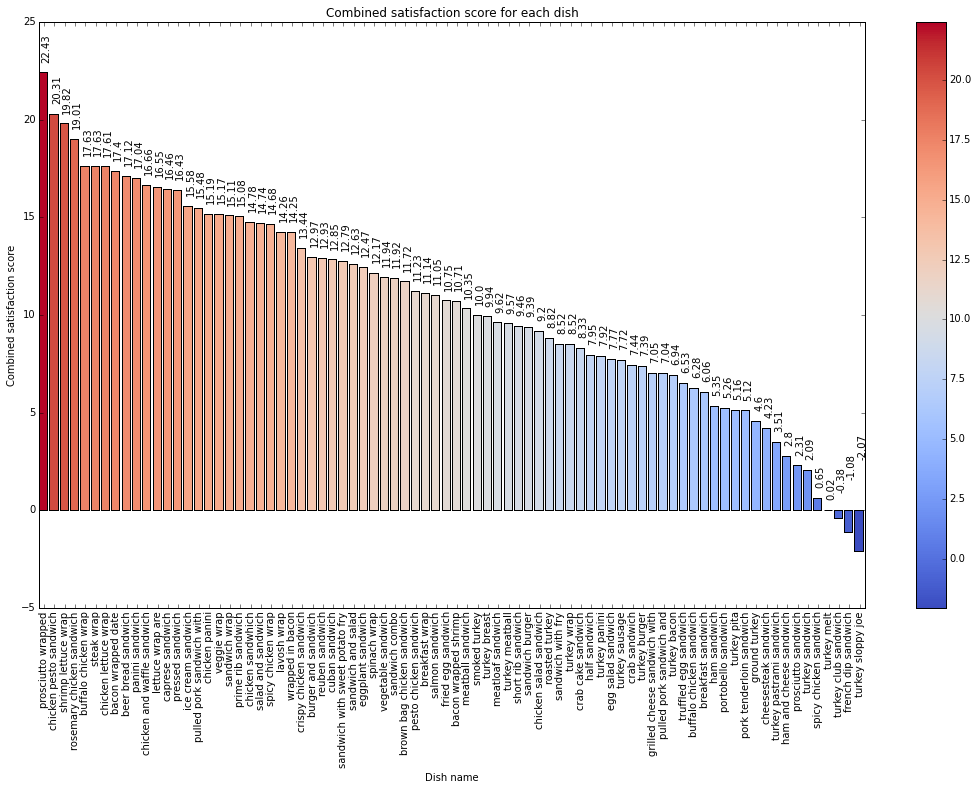

In [192]:
color_points = [val for name, val in sorted_enhanced_polarity]
labels = [round(val, 2) for name, val in sorted_enhanced_polarity]

showBar(sorted_enhanced_polarity, 
        'Combined satisfaction score for each dish', 
        'Combined satisfaction score', 
        'Dish name', labels = labels, labels_y = 0.5, color_points = color_points)

## Task 5 Restaurant Recommendation ##

My idea for task 5 was to find the best place to try sandwiches. I define for that the target name.

In [193]:
target_dish_name = 'sandwich'

I run Spark SQL search for all businesses from 'American (New)' category which have in their reviews a word 'sandwich'.

In [194]:
like_argument = "%{}%".format(target_dish_name)

targetBusinessIds = (reviewsDF
                       .filter(reviewsDF['text'].like(like_argument))
                       .join(restaurantsDF, restaurantsDF['business_id'] == reviewsDF['business_id'])
                       .select(reviewsDF['business_id'])
                       .distinct()
                       .map(lambda x: x.business_id)
                       .collect()
                    )

In [195]:
print len(targetBusinessIds)

727


It gave me 727 restaurants. After that I collected all reviews written for those restaurants to analyze. 

In [206]:
reviewsDF.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- type: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- votes: struct (nullable = true)
 |    |-- cool: long (nullable = true)
 |    |-- funny: long (nullable = true)
 |    |-- useful: long (nullable = true)



In [207]:
targetRestaurantsDF = restaurantsDF.filter(restaurantsDF['business_id'].inSet(targetBusinessIds))
                                           
targetReviewsDF = (reviewsDF
                    .join(targetRestaurantsDF, restaurantsDF['business_id'] == reviewsDF['business_id'])
                    .select(restaurantsDF['business_id'], restaurantsDF['name'],\
                            reviewsDF['review_id'], reviewsDF['stars'])
                   )

In [208]:
targetReviewsDF.count()

86047

Then I started from simple task, namely, to count how many reviews has each restaurant from the selected dataset. I sorted them by count of reviews and select only first 80.

In [241]:
import pyspark.sql.functions as F

sorted_restaurants_with_stars = (targetReviewsDF.groupBy(restaurantsDF['business_id'], restaurantsDF['name'])
 .agg(F.count('review_id'), F.avg('stars'))
 .sort(col('COUNT(review_id)').desc())
 .map(lambda x: (x[0], x[1], x[2], x[3]))
 ).take(80)                   

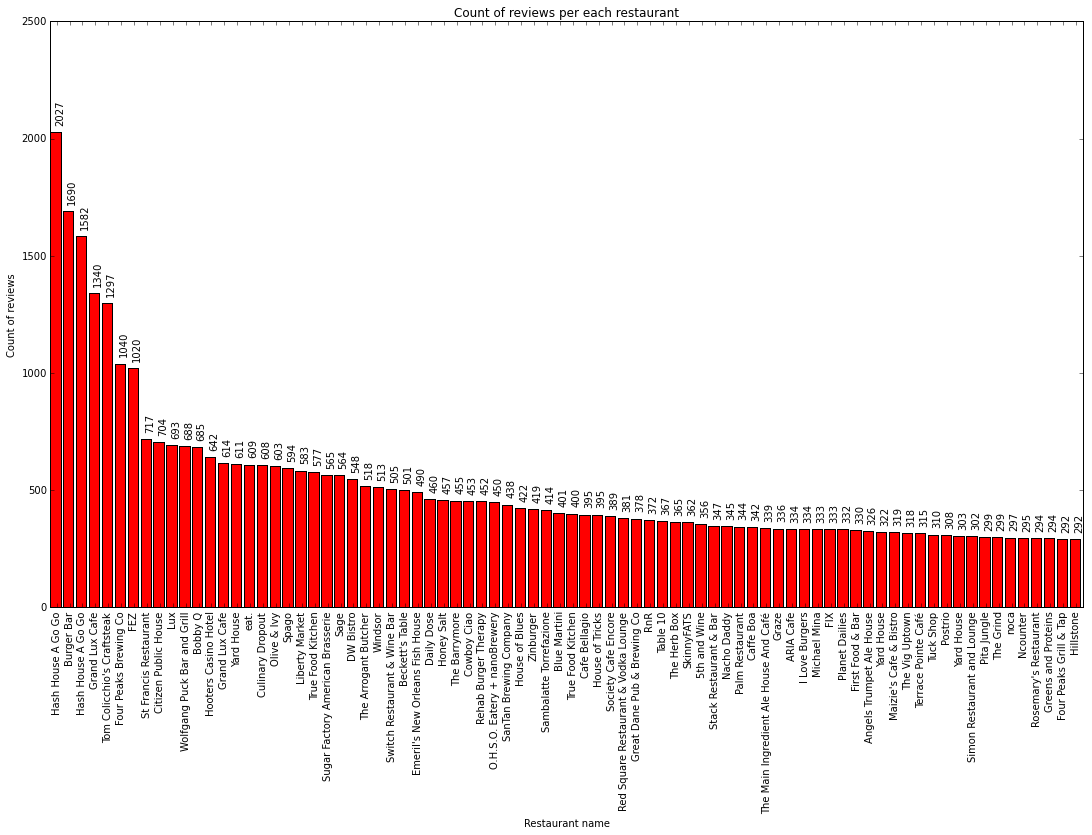

In [242]:
sorted_restaurants_name = [(name, count) for business_id, name, count, stars in sorted_restaurants_with_stars]

showBar(sorted_restaurants_name, 
        'Count of reviews per each restaurant', 
        'Count of reviews', 
        'Restaurant name', labels_y = 30)

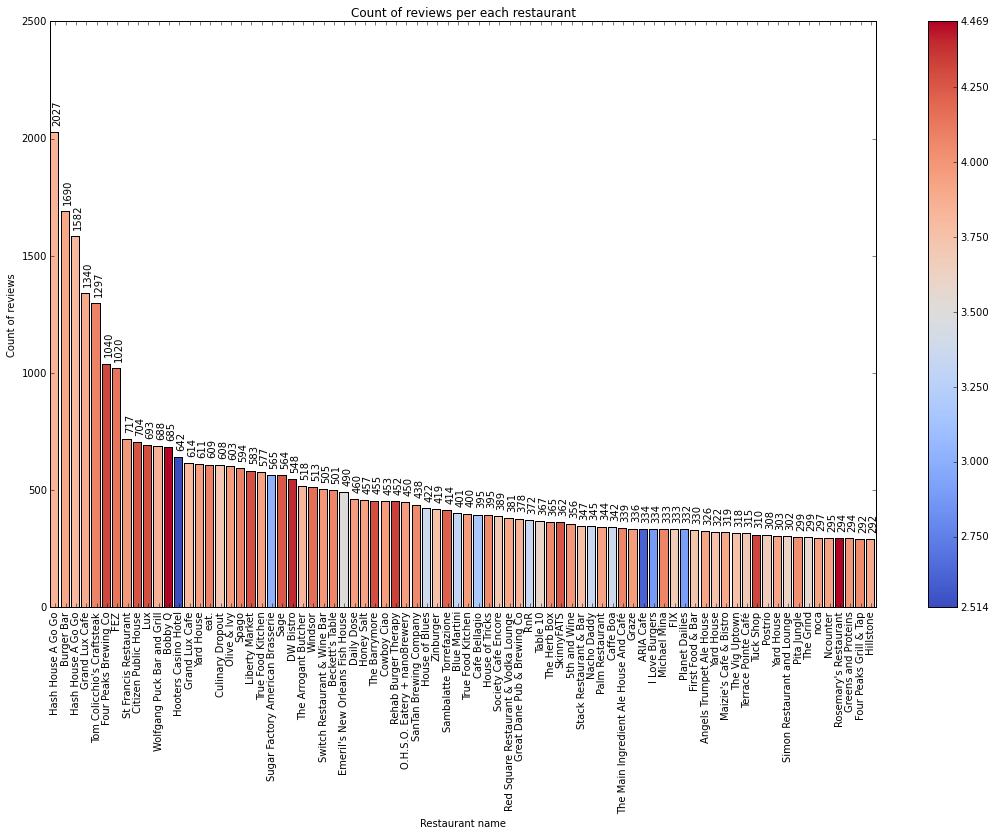

In [243]:
average_stars = [stars for business_id, name, count, stars in sorted_restaurants_with_stars]

showBar(sorted_restaurants_name, 
        'Count of reviews per each restaurant', 
        'Count of reviews', 
        'Restaurant name', labels_y = 30, color_points = average_stars,\
        middle_ticks = [2.75, 3.00, 3.25, 3.50, 3.75, 4.0, 4.25])

Because of really big number of reviews I focused only on top five restaurants from our list with highest average rating.

In [334]:
shortList = sorted(sorted_restaurants_with_stars, key=operator.itemgetter(3), reverse=True)[:10]

for x in shortList:
    print "\'{}\' number of reviews: {}\t average rating: {}".format(x[1], x[2], x[3])

'Rosemary's Restaurant' number of reviews: 294	 average rating: 4.4693877551
'Bobby Q' number of reviews: 685	 average rating: 4.46277372263
'DW Bistro' number of reviews: 548	 average rating: 4.39781021898
'Rehab Burger Therapy' number of reviews: 452	 average rating: 4.33849557522
'Tuck Shop' number of reviews: 310	 average rating: 4.32258064516
'Four Peaks Brewing Co' number of reviews: 1040	 average rating: 4.31153846154
'The Barrymore' number of reviews: 455	 average rating: 4.29230769231
'Lux' number of reviews: 693	 average rating: 4.29148629149
'Liberty Market' number of reviews: 583	 average rating: 4.27958833619
'Citizen Public House' number of reviews: 704	 average rating: 4.26704545455


In [252]:
def getIteratorOverAllReivews(business_id):
    return (reviewsDF
            .filter(reviewsDF['business_id'] == business_id)
            .select(reviewsDF['text'])
            .map(lambda x: x.text)
            )

In [332]:
shortListRestaurantsReviews = [(business_id, name, getIteratorOverAllReivews(business_id))\
                                for business_id, name, count, stars in shortList]

print shortListRestaurantsReviews

[(u'5FE1Y9cZ-YOQA943nTi7cA', u"Rosemary's Restaurant", PythonRDD[7770] at RDD at PythonRDD.scala:43), (u'rZbHg4ACfN3iShdsT47WKQ', u'Bobby Q', PythonRDD[7771] at RDD at PythonRDD.scala:43), (u'y6NFyThUU2wtTNa0rX7VrA', u'DW Bistro', PythonRDD[7772] at RDD at PythonRDD.scala:43), (u'v7OwbHgNgy_VQ9eP5FjvUA', u'Rehab Burger Therapy', PythonRDD[7773] at RDD at PythonRDD.scala:43), (u'rQ4z0EStSZE4acgkne6Hmg', u'Tuck Shop', PythonRDD[7774] at RDD at PythonRDD.scala:43), (u'JokKtdXU7zXHcr20Lrk29A', u'Four Peaks Brewing Co', PythonRDD[7775] at RDD at PythonRDD.scala:43), (u'Gvw2ewUbqq7PWkxKwjqifA', u'The Barrymore', PythonRDD[7776] at RDD at PythonRDD.scala:43), (u'aRkYtXfmEKYG-eTDf_qUsw', u'Lux', PythonRDD[7777] at RDD at PythonRDD.scala:43), (u'L9UYbtAUOcfTgZFimehlXw', u'Liberty Market', PythonRDD[7778] at RDD at PythonRDD.scala:43), (u'MuIXnv7Oq7X3-4aEsp9dDA', u'Citizen Public House', PythonRDD[7779] at RDD at PythonRDD.scala:43)]


In [270]:
reviewsDir = os.path.join(workingDir, 'reviews')

def writeReviews(business_id, name, rdd):
    reviewsFile = os.path.join(reviewsDir, '{}.txt'.format(business_id))
    reviewsIt = rdd.toLocalIterator()

    with open(reviewsFile, 'w') as f:
        for line in reviewsIt:
            line = ' '.join(line.encode('utf-8').split())
            f.write(line)
            f.write('\n')

In [333]:
for business_id, name, rdd in shortListRestaurantsReviews[]:
    writeReviews(business_id, name, rdd)

In [341]:
def evaluateSentimentsAverage(business_id):
    reviewsFile = os.path.join(reviewsDir, '{}.out'.format(business_id))
    
    return (sc.textFile(reviewsFile)
            .map(lambda x: float(x[-20:].split()[-2]))
           ).mean()


In [342]:
setiments_per_restaurants = [(name, evaluateSentimentsAverage(business_id))\
                             for business_id, name, rdd in shortListRestaurantsReviews]


In [343]:
print setiments_per_restaurants


[(u"Rosemary's Restaurant", 1.727891156462585), (u'Bobby Q', 1.9781021897810205), (u'DW Bistro', 1.9507299270072997), (u'Rehab Burger Therapy', 1.9115044247787616), (u'Tuck Shop', 1.7774193548387096), (u'Four Peaks Brewing Co', 1.9076923076923078), (u'The Barrymore', 1.9318681318681317), (u'Lux', 1.8297258297258296), (u'Liberty Market', 1.859348198970841), (u'Citizen Public House', 1.8153409090909094)]


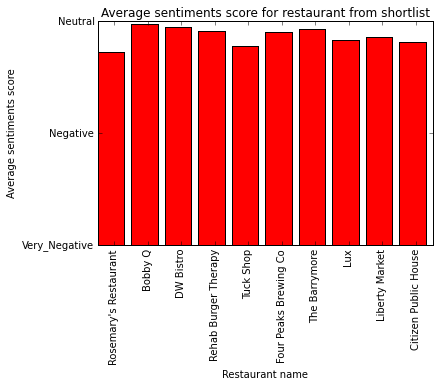

In [344]:
%matplotlib inline

import operator
import numpy as np
import matplotlib.pyplot as plt

length = len(setiments_per_restaurants)
ind = np.arange(length)
width = 0.5
    
counts = [c for names, c in setiments_per_restaurants]
    
fig, ax = plt.subplots()
bar = ax.bar(ind, counts, color='r')

ax.set_title('Average sentiments score for restaurant from shortlist')
ax.set_ylabel('Average sentiments score')
ax.set_xlabel('Restaurant name')

plt.xticks(ind + width, [name for (name, c) in setiments_per_restaurants], rotation='vertical') 
plt.yticks([0.0, 1.0, 2.0], ['Very_Negative', 'Negative', 'Neutral'])
    
fig.savefig('short_list_sentiment.png', dpi=200)

plt.show()

In [351]:
restaurantsDF.filter(col("business_id") == "rZbHg4ACfN3iShdsT47WKQ").select('full_address').collect()

[Row(full_address=u'8501 N 27th Ave\nPhoenix, AZ 85051')]